# COSMOS2020 Photometric Redshifts estimation with EAZY

Shirui Wei

* **Data prepation**: prepare files with specific format for EAZY, including input catalog, parameters file, template files, filter files and translate files.

In [3]:
from astropy.io import fits
from astropy.io import fits,ascii,votable
from astropy import units as u 
from astropy import constants as const
from astropy import table
import eazy
import os
import sys
import numpy as np
from tqdm import tqdm

Failed to `import dust_attenuation`
Install my fork with $ pip install git+https://github.com/gbrammer/dust_attenuation.git


## Data Prepation

### Input Catalog
process NaN

Only select some columns, including ID, RA, DEC, some filters and photo-z(Weaver et al 2022 for validation).

In [4]:
catversion = 'Farmer'
fitversion = 'ez' 
flx = '_FLUX'  
flxerr = '_FLUXERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'cgs' # 'cgs' or 'uJy'
catalog_raw_file = '/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/COSMOS2020_Farmer_processed_0111.fits'

In [5]:
with fits.open(catalog_raw_file) as cat_hdu:
    cat_hdu.info()
    cat_data = cat_hdu[1].data
    cat_header = cat_hdu[1].columns.names

Filename: /data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/COSMOS2020_Farmer_processed_0111.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  PHASE3CATALOG    1 BinTableHDU   1144   746976R x 105C   [K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E, E, E, E, E, E, E, E, E, E, E, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [6]:
# remove data whose photo-z is nan:
cat_data = cat_data[~np.isnan(cat_data['photoz'])]
# fill nan with a Negative value:
NOT_OBS_THRESHOLD = -90
for k in cat_header:
    # only correct flux and fluxerr
    if k.endswith(flxerr) or k.endswith(flx):
        cat_data[k] = np.nan_to_num(cat_data[k],nan=NOT_OBS_THRESHOLD)

In [7]:
len(cat_data)

671190

In [42]:
# select specific columns:
filt_use = ['HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2']
keep_columns = ['ID','RA','DEC']
for i in filt_use:
    keep_columns.append(i+flx)
    keep_columns.append(i+flxerr)
keep_columns.append('photoz')
keep_columns_idx = [cat_header.index(i) for i in keep_columns]

In [51]:
cat_data_new = cat_data.columns[0:3]
for i in keep_columns_idx[3:]:
    cat_data_new=cat_data_new+cat_data.columns[i]

In [52]:
cat_data_new

ColDefs(
    name = 'ID'; format = 'K'; null = -99
    name = 'RA'; format = 'D'; unit = 'deg'
    name = 'DEC'; format = 'D'; unit = 'deg'
    name = 'HSC_g_FLUX'; format = 'D'; unit = 'erg Hz-1 s-1 cm-2'
    name = 'HSC_g_FLUXERR'; format = 'D'; unit = 'erg Hz-1 s-1 cm-2'
    name = 'HSC_r_FLUX'; format = 'D'; unit = 'erg Hz-1 s-1 cm-2'
    name = 'HSC_r_FLUXERR'; format = 'D'; unit = 'erg Hz-1 s-1 cm-2'
    name = 'HSC_i_FLUX'; format = 'D'; unit = 'erg Hz-1 s-1 cm-2'
    name = 'HSC_i_FLUXERR'; format = 'D'; unit = 'erg Hz-1 s-1 cm-2'
    name = 'HSC_z_FLUX'; format = 'D'; unit = 'erg Hz-1 s-1 cm-2'
    name = 'HSC_z_FLUXERR'; format = 'D'; unit = 'erg Hz-1 s-1 cm-2'
    name = 'HSC_y_FLUX'; format = 'D'; unit = 'erg Hz-1 s-1 cm-2'
    name = 'HSC_y_FLUXERR'; format = 'D'; unit = 'erg Hz-1 s-1 cm-2'
    name = 'UVISTA_Y_FLUX'; format = 'D'; unit = 'erg Hz-1 s-1 cm-2'
    name = 'UVISTA_Y_FLUXERR'; format = 'D'; unit = 'erg Hz-1 s-1 cm-2'
    name = 'UVISTA_J_FLUX'; format = 'D'; un

In [60]:
# write to catalog:
cat_hdu_new = fits.BinTableHDU.from_columns(cat_data_new)
cat_hdu_new.writeto('/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/catalog_0111.fits')

### Translate file
match filters used in COSMOS2020 with EAZY FILTER.RES.latest.info

rename columns to meet EAZY'requirements.

In [66]:
# fiter和EAZY filter res对应关系
cosmos_eazy_filter = {}
cosmos_eazy_filter['HSC_g'] = 314
cosmos_eazy_filter['HSC_r'] = 315
cosmos_eazy_filter['HSC_i'] = 316
cosmos_eazy_filter['HSC_z'] = 317
cosmos_eazy_filter['HSC_y'] = 318
cosmos_eazy_filter['UVISTA_Y']=256
cosmos_eazy_filter['UVISTA_J']=257
cosmos_eazy_filter['UVISTA_H']=258
cosmos_eazy_filter['UVISTA_Ks']=259
cosmos_eazy_filter['IRAC_CH1'] = 18
cosmos_eazy_filter['IRAC_CH2'] = 19

In [68]:
# translate file:
with open('/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/cosmos2020.translate','w') as trans_file:
    for key in cat_hdu_new.columns.names:
        if key in ['ID','RA','DEC']:
            trans = key.lower()
        elif key == 'photoz':
            trans = 'z_spec'
        else:
            if key.endswith(flxerr):
                key_filter = key[:-8]
                trans = 'E'+str(cosmos_eazy_filter[key_filter])
            else:
                key_filter = key[:-5]
                trans = 'F'+str(cosmos_eazy_filter[key_filter])
        trans_file.write(f'{key} {trans}\n')

## Run EAZY

In [70]:
param_file ='/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/cosmos2020.param.default'
translate_file = '/data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/cosmos2020.translate'

In [74]:
# Run EAZY
pz_obj = eazy.photoz.PhotoZ(param_file=param_file, translate_file=translate_file, zeropoint_file=None, 
                          params={}, load_prior=False, load_products=False)

Read default param file: /data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/cosmos2020.param.default
Read CATALOG_FILE: /data/home/wsr/WorkSpace/EAZY/cosmos2020-readcat/COSMOS2020_Farmer_EAZY/catalog_0111.fits
   >>> NOBJ = 746976
HSC_g_FLUX HSC_g_FLUXERR (314): g_HSC.txt
HSC_r_FLUX HSC_r_FLUXERR (315): r_HSC.txt
HSC_i_FLUX HSC_i_FLUXERR (316): i_HSC.txt
HSC_z_FLUX HSC_z_FLUXERR (317): z_HSC.txt
HSC_y_FLUX HSC_y_FLUXERR (318): y_HSC.txt
UVISTA_Y_FLUX UVISTA_Y_FLUXERR (256): VISTA/Y_system+atmos.dat
UVISTA_J_FLUX UVISTA_J_FLUXERR (257): VISTA/J_system+atmos.dat
UVISTA_H_FLUX UVISTA_H_FLUXERR (258): VISTA/H_system+atmos.dat
UVISTA_Ks_FLUX UVISTA_Ks_FLUXERR (259): VISTA/Ks_system+atmos.dat
IRAC_CH1_FLUX IRAC_CH1_FLUXERR ( 18): IRAC/irac_tr1_2004-08-09.dat
IRAC_CH2_FLUX IRAC_CH2_FLUXERR ( 19): IRAC/irac_tr2_2004-08-09.dat
Set sys_err = 0.01 (positive=True)
Template grid: /data/home/wsr/WorkSpace/EAZY/eazy-photoz/templates/fsps_full/tweak_fsps_QSF_12_v3.param (this may 

100%|██████████| 12/12 [04:23<00:00, 21.96s/it]


Template   0: tweak_fsps_QSF_12_v3_001.dat (NZ=1).
Template   1: tweak_fsps_QSF_12_v3_002.dat (NZ=1).
Template   2: tweak_fsps_QSF_12_v3_003.dat (NZ=1).
Template   3: tweak_fsps_QSF_12_v3_004.dat (NZ=1).
Template   4: tweak_fsps_QSF_12_v3_005.dat (NZ=1).
Template   5: tweak_fsps_QSF_12_v3_006.dat (NZ=1).
Template   6: tweak_fsps_QSF_12_v3_007.dat (NZ=1).
Template   7: tweak_fsps_QSF_12_v3_008.dat (NZ=1).
Template   8: tweak_fsps_QSF_12_v3_009.dat (NZ=1).
Template   9: tweak_fsps_QSF_12_v3_010.dat (NZ=1).
Template  10: tweak_fsps_QSF_12_v3_011.dat (NZ=1).
Template  11: tweak_fsps_QSF_12_v3_012.dat (NZ=1).
Process templates: 265.280 s


256it [00:45,  5.63it/s]


In [81]:
pz_obj.set_sys_err(positive=True)
sample = np.isfinite(pz_obj.ZSPEC)
pz_obj.fit_catalog(pz_obj.idx[sample], n_proc=8)

Set sys_err = 0.01 (positive=True)


100%|██████████| 256/256 [16:50<00:00,  3.95s/it]


Compute best fits
fit_best: 0.0 s (n_proc=1,  NOBJ=0)
Fit 1016.1 s (n_proc=8, NOBJ=671190)


/data/home/wsr/.conda/envs/COSMOS2020/lib/python3.10/site-packages/eazy/templates.py:104: RuntimeWarning: divide by zero encountered in divide
  lcz = np.atleast_1d(self.filter_wavelengths)/(1+z)
/data/home/wsr/.conda/envs/COSMOS2020/lib/python3.10/site-packages/eazy/templates.py:105: RuntimeWarning: divide by zero encountered in divide
  tef_z = self._spline(np.atleast_1d(self.filter_wavelengths)/(1+z))
/data/home/wsr/.conda/envs/COSMOS2020/lib/python3.10/site-packages/eazy/igm.py:193: RuntimeWarning: divide by zero encountered in scalar power
  return a**b
/data/home/wsr/.conda/envs/COSMOS2020/lib/python3.10/site-packages/eazy/photoz.py:2701: RuntimeWarning: divide by zero encountered in divide
  flam_spec = utils.CLIGHT*1.e10/templz**2/1.e-19
/data/home/wsr/.conda/envs/COSMOS2020/lib/python3.10/site-packages/eazy/photoz.py:2718: RuntimeWarning: invalid value encountered in multiply
  templf=templf*fnu_factor*flam_spec,
/data/home/wsr/.conda/envs/COSMOS2020/lib/python3.10/site-packag

(<Figure size 800x400 with 2 Axes>,
 OrderedDict([('ix', 56),
              ('id', 100),
              ('z', -1.0),
              ('z_spec', 0.3945297),
              ('pivot',
               array([ 4797.34688472,  6148.51620499,  7603.45686736,  8901.92815402,
                       9643.91553837, 10215.74297393, 12526.23491601, 16432.82008153,
                      21503.4501456 , 35569.29566469, 45020.33785231])),
              ('model',
               array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])),
              ('emodel', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])),
              ('fobs',
               array([-468.22398052, -285.04619856, -186.39477078, -135.98397368,
                      -115.86415568, -103.25616291,  -68.67754991,  -39.90540262,
                       -23.30449008,   -8.51736712,   -5.316654  ])),
              ('efobs',
               array([-468.22398052, -285.04619856, -186.39477078, -135.98397368,
                      -115.86415

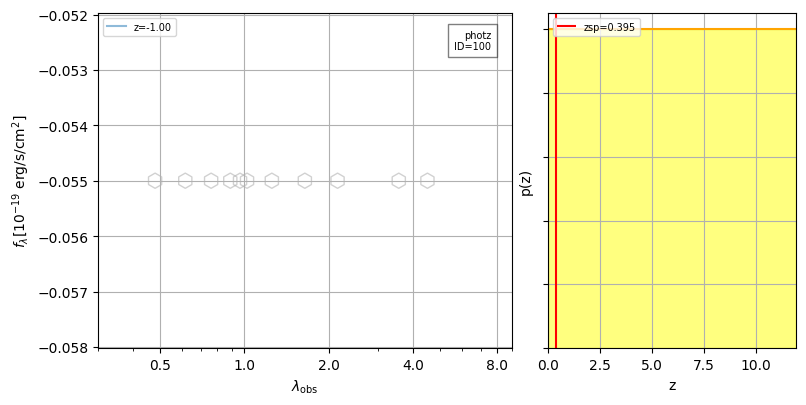

In [83]:
pz_obj.show_fit(100)